<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Title

Meixin Zhang, 

At the top, the notebook should have a clear title, your name,

### *Abstract*

a separate cell with a concise two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project. 


### Team Members and Contributions

This cell should contain an itemized list of all team members. Each item (bullet) should start with a name and detail this person's contributions. 

- Meixin: 


### Code Libraries

You should also have a separate cell titled code libraries acknowledging all external code libraries "essential" for your project. You should explain the importance of each such library for your project. 

If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory. 

If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory. For group projects, you can refer to your team's libraries in the earlier "contributions" section. At the bottom of your notebook, you should include a cell with two-three paragraphs summarizing the conclusions of your project.


In [1]:
# Packages
import numpy as np
import numpy.linalg as la
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
from skimage.transform import EssentialMatrixTransform
from skimage.color import rgb2gray

# Our Libraries 
from mylibs.structure_from_motion_lib import (
    get_matched_keyppoints, 
    matchedpoints_to_pairpoints, 
    camera_calib_nomalization,
    #estimate_ufl,
)

from mylibs.my_graph_cut import MaskBuilder, MyGraphCuts

## Implementation

Unsupervised detection and segmentation of (multiple) rigidly moving objects. 

You can detect multiple fundamental matrices while matching sparse features (Topics 6-7) and integrate these into loss functions for dense segmentation (topic 9). Essentially, this can be implemented as a combination of methods in HW3 and HW4. You can use any (pairs of) images for this project

Different parts of an image going through different kinds of movements (different essential/fundamental matrices)  - UFL

Use RANSAC/UFL for inlier matches multiple times, then find different fundamental matrices from that. categorize points through this and this is used as a mask for segmentation

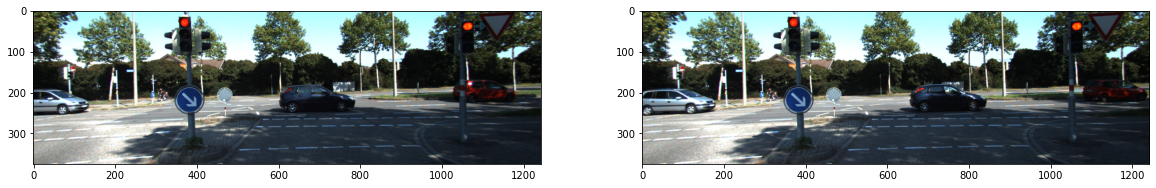

In [2]:
%matplotlib inline

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Structure from Motion Using UFL and Epipolar Geometry

#### Step 1: Feature Detection and Matching

Detect corners on the given pictures using Harris corner detector and match using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 199


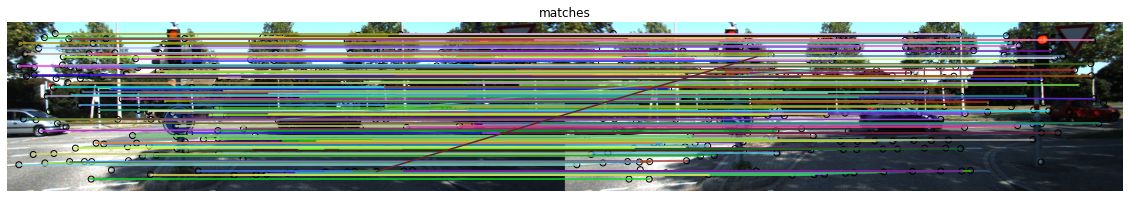

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL, keypointsR, matchesLR = get_matched_keyppoints(imLgray, imRgray)

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

Recall that normalization of camera in the two images is given by multiplying the points by $K^{-1}$, where $K$ is the calibration parameters of the camera.


In [19]:
def estimate_ufl (src_pts, dst_pts, K = 100, gamma = 0.01, T = 1e-20) :
    """
    Estimates a homography from src_pts to dst_pts using the UFL method.
    K is the number of initial points to choose from
    """
    assert len(src_pts) == len(dst_pts)
    num_pts = len(src_pts)

    # Initial set of models
    models = []

    # 1. Randomly choose K lines
    for i in range(K) :
        # Randomly choose 8 points
        random_idx = np.random.choice(num_pts, 8, replace=False)
        src_random = src_pts[random_idx]
        dst_random = dst_pts[random_idx]
        # Fit a homography through them
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_random, dst_random) :
            models.append(EMT.params)
            # print(np.diag(np.hstack((dst_random, np.ones((8,1)))) @ EMT.params @ np.vstack((src_random.T, np.ones(8)))))

    # Remove duplicates in the initial set of models
    models = np.unique(np.array(models), axis=0)

    # Homogeneous coordinates
    dst_hom = np.hstack((dst_pts, np.ones((num_pts,1))))
    src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

    # Iteration of steps 2 and 3
    def iterate (models, pts_to_models = np.zeros(num_pts)-1) :

        # 2a. Nearest model for each point
        nearest_models = np.zeros(num_pts)-1
        # Nearest distances for each point
        distances = np.zeros(num_pts)+np.Inf

        # Find nearest model for each point
        for i in range(len(models)) :
            # Distances for each point to the current model
            model_dists = np.diag(dst_hom @ models[i] @ src_hom)
            # Update points where the current model has smaller distance
            nearest_models[np.where((model_dists < distances) & (model_dists < T))] = i
            # Update distances
            distances = np.minimum(distances, model_dists)

        # 2b. The list of resulting models
        result_models = []

        # Readjust parameters for each model to better fit the inliers
        for i in range(len(models)) :
            # The inlier index
            inlier_idx = np.where(nearest_models == i)[0]
            # Skip if no inliers
            if len(inlier_idx) < 8 :
                continue
            # Inlier points
            src_inliers = src_pts[inlier_idx]
            dst_inliers = dst_pts[inlier_idx]
            # Make the model more precise by re-estimating using only the inliers
            EMT = EssentialMatrixTransform()
            if EMT.estimate(src_inliers, dst_inliers) :
                pts_to_models[inlier_idx] = len(result_models)
                result_models.append(EMT.params)

        #print(len(result_models))
                
        # 3. Decide whether or not to keep each model
        for i in range(len(result_models)) :
            # Points assigned to this model
            model_src_pts = src_pts[np.where(pts_to_models == i)]
            model_dst_pts = dst_pts[np.where(pts_to_models == i)]
            # Distances for each point to this model
            model_dists = np.diag(dst_hom @ result_models[i] @ src_hom)[np.where(pts_to_models == i)]
            # The cost of keeping this model is the cost of assigning points
            # to this model plus the maintenance gamma
            keep_cost = np.sum(model_dists) + gamma
            # Find the nearest model for each point excluding the current model
            remove_model_dists = np.zeros(num_pts)+np.Inf
            # Nearest model for each point after the current model is removed
            remove_nearest_models = pts_to_models
            for j in range(len(result_models)) :
                # Skip if it's the current model under consideration
                if j == i :
                    continue
                dists = np.diag(dst_hom @ models[j] @ src_hom)
                # Distances for each point to the model
                remove_nearest_models[np.where(dists < remove_model_dists)] = j
                remove_model_dists = np.minimum(remove_model_dists, dists)
            # Cost of removing the model
            remove_cost = np.sum(remove_model_dists[np.where(result_models == i)])
            # Remove the model if the cost of keeping is greater
            if remove_cost < keep_cost :
                pts_to_models[np.where(pts_to_models) == i] = remove_nearest_models[np.where(pts_to_models) == i]

        # Calculate the energy of the current configuration
        energy = 0
        for i in range(len(result_models)) :
            # Points assigned to this model
            model_src_pts = src_pts[np.where(pts_to_models == i)]
            model_dst_pts = dst_pts[np.where(pts_to_models == i)]
            # Distances for each point to this model
            model_dists = np.diag(dst_hom @ result_models[i] @ src_hom)[np.where(pts_to_models == i)]
            # The cost of keeping this model is the cost of assigning points
            # to this model plus the maintenance gamma
            energy = energy + np.sum(model_dists) + gamma

        return result_models, pts_to_models, energy

    result_models, pts_to_models, energy = iterate(models)
    print(f'energy = {energy}')
    iter_num = 0
    while iter_num < 1 :
        iter_num = iter_num+1
        result_models, pts_to_models, energy_update = iterate(result_models)
        print(f'energy = {energy_update}, num classes = {len(np.unique(pts_to_models))}')
        if energy_update == energy :
            return result_models, pts_to_models
        else :
            energy = energy_update

    return result_models, pts_to_models


energy = -2.499306430014787
energy = -1.6200971218702491, num classes = 2
the number of classes found by ufl is 2
the number of ufl inliers is 199


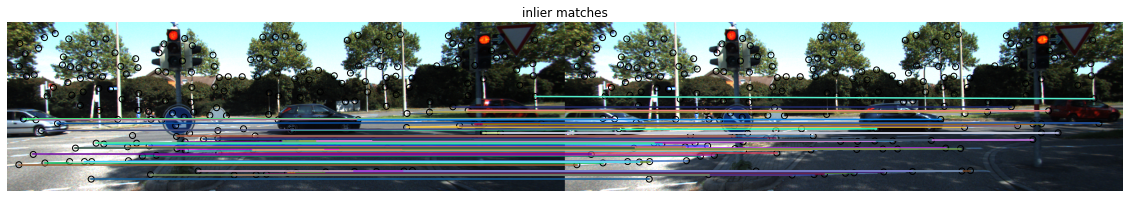

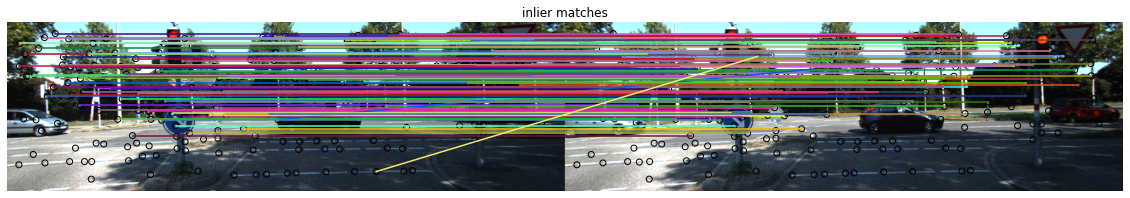

In [21]:
ptsL_inv, ptsR_inv = matchedpoints_to_pairpoints(keypointsL, keypointsR, matchesLR)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL, ptsR = ptsL_inv[:,[1, 0]], ptsR_inv[:,[1, 0]]

n_ptsL = camera_calib_nomalization(ptsL, K)
n_ptsR = camera_calib_nomalization(ptsR, K)

# robustly estimate essential matrices using normalized points and UFL
E_ufl_trans, E_ufl_models = estimate_ufl(n_ptsL, n_ptsR)
num_inliers = len(np.where(E_ufl_models > -1)[0])
num_classes = int(max(E_ufl_models) + 1)
print ('the number of classes found by ufl is {:d}'.format(num_classes))
print ('the number of ufl inliers is {:d}'.format(num_inliers))

# Show the inliers for the different classes
for i in range(num_classes):
    E_i = E_ufl_trans[i]    # Singular values for E
    E_inliers_i = np.where(E_ufl_models == i)[0]

    ind = np.ogrid[:n_ptsL.shape[0]]
    EmatchesRansac = np.column_stack((ind[E_inliers_i],ind[E_inliers_i]))

    fig = plt.figure(5+i,figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title("inlier matches")
    plt.gray()
    # NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
    plot_matches(axA, imL, imR, ptsL_inv, ptsR_inv, EmatchesRansac)
    axA.axis('off')
    plt.show()

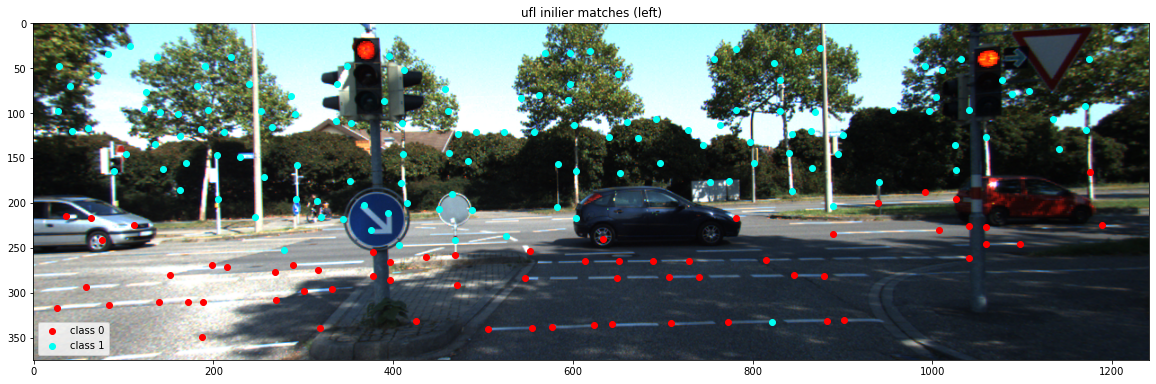

In [22]:
# Maps object points to colours
c_map = plt.cm.get_cmap('hsv', num_classes+1)

ufl_l_fig = plt.figure(12,figsize = (20, 8))
ufl_l_ax = plt.subplot(111)
ufl_l_ax.set_title("ufl inilier matches (left)")
ufl_l_ax.imshow(imL)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsL[np.where(E_ufl_models == i)]
    ufl_l_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_l_ax.legend()


In [ ]:
ufl_r_fig = plt.figure(13,figsize = (20, 8))
ufl_r_ax = plt.subplot(111)
ufl_r_ax.set_title("ufl inilier matches (right)")
ufl_r_ax.imshow(imR)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsR[np.where(E_ufl_models == i)]
    ufl_r_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_r_ax.legend()

### Use the Classes From UFL for Segmentation

you should implement graph cut algorithm for minimizing the loss (see slide 182 topic 9)
Iterative learning of color models, GrabCut: iterated graph cuts

$$ -\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda \sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ 

$$ -\sum_p \log Pr(I_p\,|\,\theta_{S_p}) \;\;-\;\;\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda\sum_{pq\in N} w_{pq}\,[S_p \neq S_q] + |labels|$$ 

combining the seed loss (hard constraints for user-defined labels) and basic pair-wise regularization loss with "contrast-weights" $w_{pq} = \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for 4-connected grid neighborhood. Note that the scalar (hyper-parameter) $\lambda$ controlling the regularization strength can be integrated into edge weights $\tilde{w}_{pq} = \lambda \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ (parameter $\lambda$ is primarily needed for the second milestone below). Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals.

You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{\tilde{w}_{pq}\}\equiv N\lambda$ (number of neighbors at each point times the largest n-link weight) is sufficient.

multi-terminal graph cuts are needed for segmentation step [BVZ, PAMI 2001]

In [ ]:
seed_mask_left = MaskBuilder(imL.shape[0], imL.shape[1], MyGraphCuts.none_value)
for i in range(num_classes):
    class_pts = ptsL[np.where(E_ufl_models == i)]
    for pt in class_pts:
        seed_mask_left.add_disk(pt[0], pt[1], 3, i)

# gc = MyGraphCuts(imL, sigma=0.5, lam=50)
# seg = gc.compute_labels(seed_mask_left.get_mask())

## Conclusion


You should include a cell with two-three paragraphs summarizing the conclusions of your project.
